# Data description

This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

* **Surname:** The surname of the customer
* **CreditScore:** The credit score of the customer
* **Geography:** The country of the customer(Germany/France/Spain)
* **Gender:** The gender of the customer (Female/Male)
* **Age:** The age of the customer
* **Tenure:** The customer's number of years in the in the bank
* **Balance:** The customer's account balance
* **NumOfProducts:** The number of bank products that the customer uses
* **HasCrCard:** Does the customer has a card? (0=No,1=Yes)
* **IsActiveMember:** Does the customer has an active mebership (0=No,1=Yes)
* **EstimatedSalary:** The estimated salary of the customer
* **Exited:** Churned or not? (0=No,1=Yes)

In [1]:
import pandas as pd #to load and manipulate data
import numpy as np
import matplotlib.pyplot as plt #to draw graphs 
import seaborn as sns #to draw graphs 
from sklearn.model_selection import train_test_split #to split data into training and testing sets
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix #to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix  #to draw a confusion matrix
from sklearn.metrics import accuracy_score, precision_score, classification_report #to plot score information
from warnings import filterwarnings
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import shap

ModuleNotFoundError: No module named 'imblearn'

In [2]:
df = pd.read_csv(r"C:\Users\lpennella\Desktop/Master/Hands-on labs/DB/Churn_Modelling.csv")

# First Exploration

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
print('N. of rows: {}'.format(df.shape[0]))
print('N. of columns: {}'.format(df.shape[1]))

N. of rows: 10000
N. of columns: 14


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


There are no null values. We can observe how there are columns of type object, which identify classes. We will then proceed to encode these specific features.

I proceed to delete the *RowNumber*, *CustomerId* and *Surname* columns because they are not very useful information at the end of the churn forecast.

In [8]:
new_df = df.drop(df.columns[0:3], axis=1)
new_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
new_df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [13]:
cat_cols = new_df.select_dtypes('object')
for i in cat_cols:
    d = new_df[i].value_counts()
    print(d)

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
Male      5457
Female    4543
Name: Gender, dtype: int64


In [14]:
new_df['Balance'] = new_df['Balance'].apply(np.int64)
new_df['EstimatedSalary'] = new_df['EstimatedSalary'].apply(np.int64)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CreditScore      10000 non-null  int64 
 1   Geography        10000 non-null  object
 2   Gender           10000 non-null  object
 3   Age              10000 non-null  int64 
 4   Tenure           10000 non-null  int64 
 5   Balance          10000 non-null  int64 
 6   NumOfProducts    10000 non-null  int64 
 7   HasCrCard        10000 non-null  int64 
 8   IsActiveMember   10000 non-null  int64 
 9   EstimatedSalary  10000 non-null  int64 
 10  Exited           10000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 859.5+ KB


In [15]:
new_df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

79.6% of the instances of our target variable are not churned customers. Instead, 20.4% of the instances of our target variable are churned customers.

# Exploratory Data Analysis

In [16]:
num_cols = new_df.select_dtypes(['int64'])

Geography  Exited
France     0         4204
           1          810
Germany    0         1695
           1          814
Spain      0         2064
           1          413
Name: Exited, dtype: int64


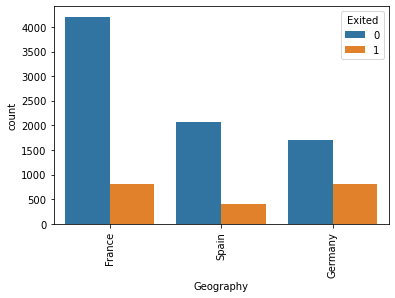

Gender  Exited
Female  0         3404
        1         1139
Male    0         4559
        1          898
Name: Exited, dtype: int64


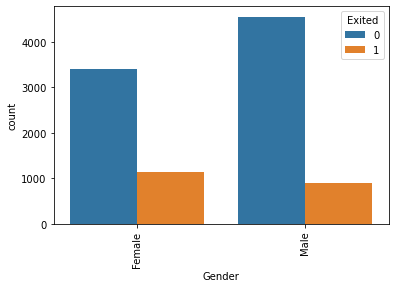

In [17]:
for col in cat_cols:
    print(new_df.groupby([col,'Exited'])['Exited'].count())
    sns.countplot(x=new_df[col], hue=new_df['Exited'])
    plt.xticks(rotation=90)
    plt.show()

**Geography**
* French customers are the largest class.
* In percentage, German customers are the most churned customers.

**Gender**
* Male customera are the largest class.
* In percentage, Female customers are the most churned customers.

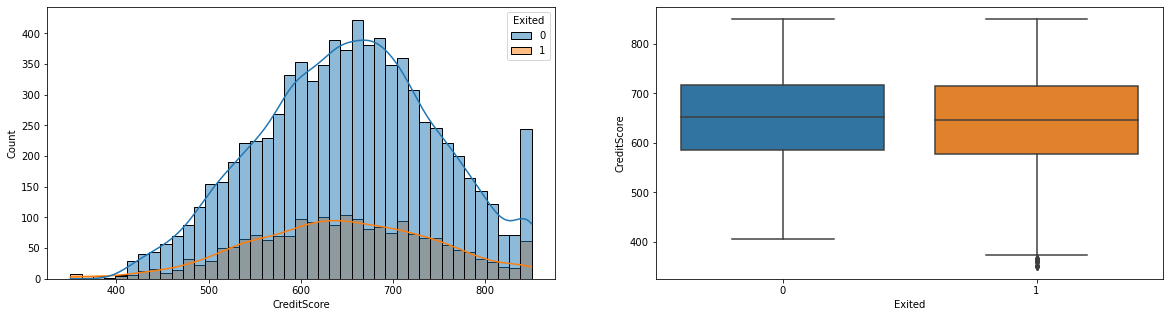

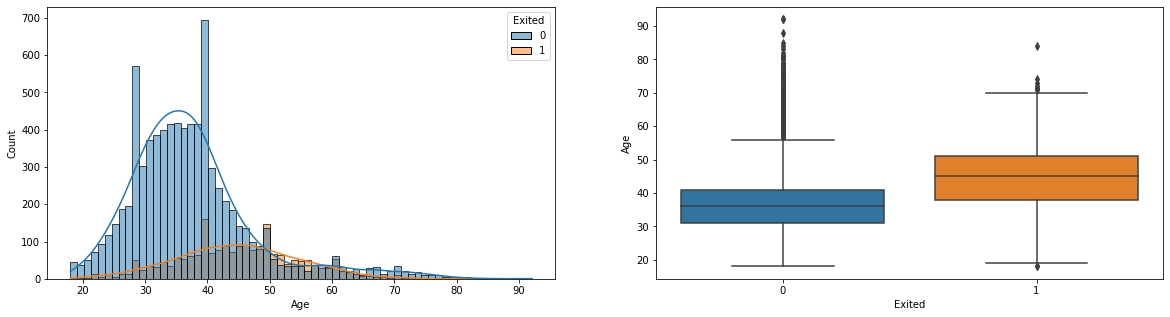

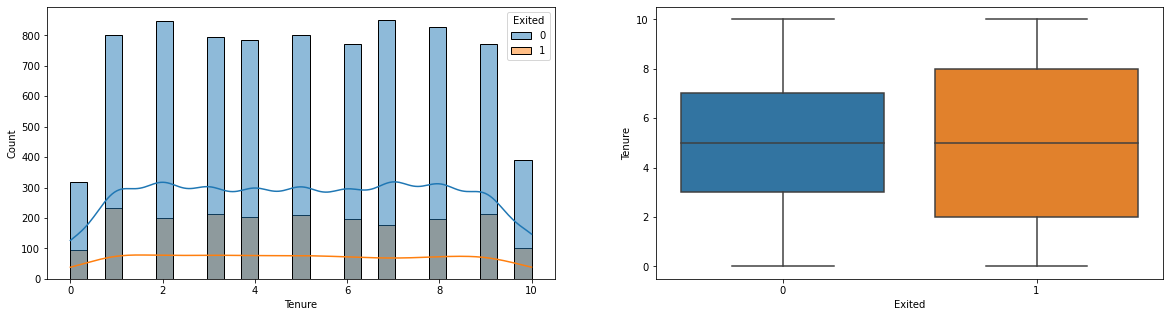

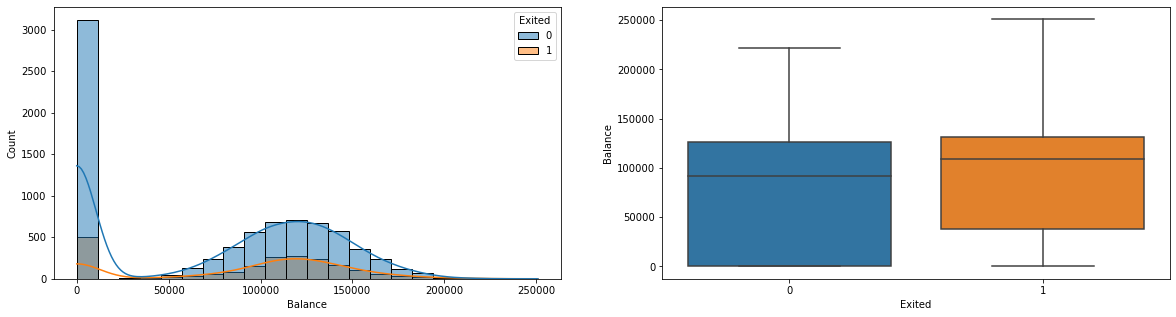

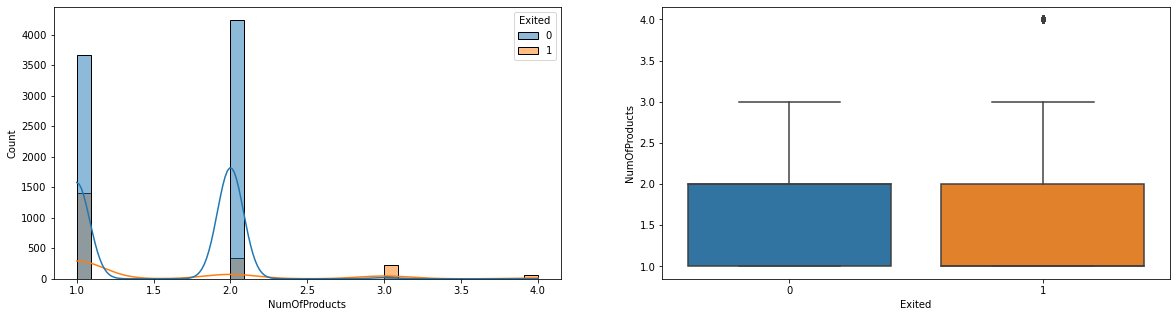

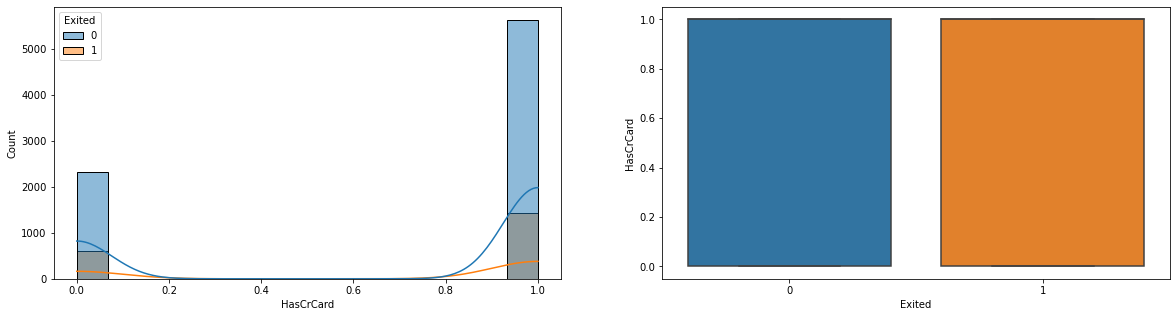

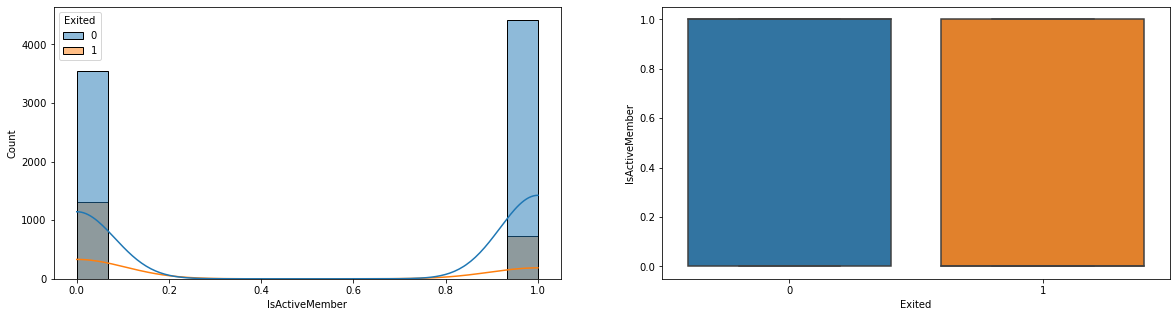

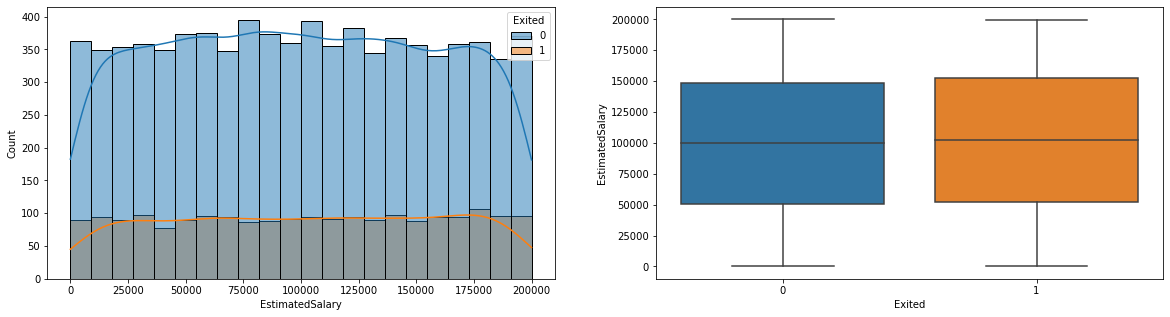

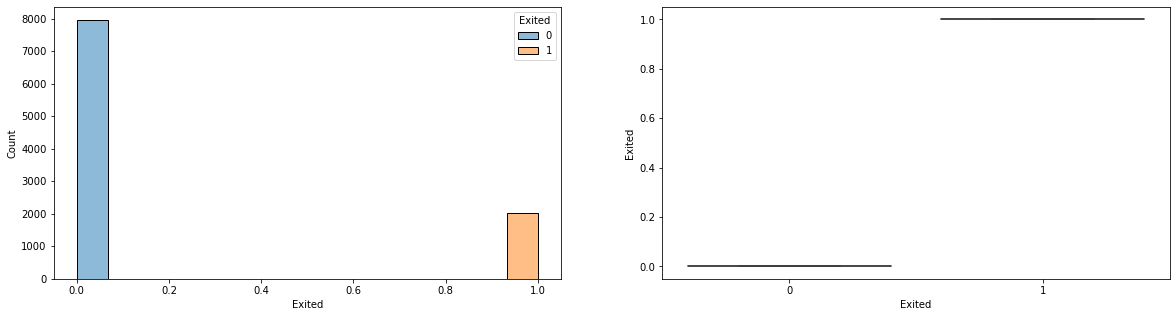

In [19]:
for col in num_cols:
    f, axis = plt.subplots(1,2, figsize=(20, 5))
    sns.histplot(data =new_df, x=col, ax=axis[0], kde=True, hue = "Exited")
    sns.boxplot(x=new_df['Exited'], y=new_df[col], ax=axis[1])
    plt.show()

**Credit Score**
* *Credit Score* attribute is not symmetric.
*  Looking at the boxplots, it is not possible to see hypothetical relation with target features.

**Age**
* *Age* attribute is not symmetric, we have a positive skew.
*  Minimum and Maximum age of the people is 18 and 92 respectively.
*  Looking at the boxplots, it is possible to see that in proportion as age increases, the probability of churn increase.

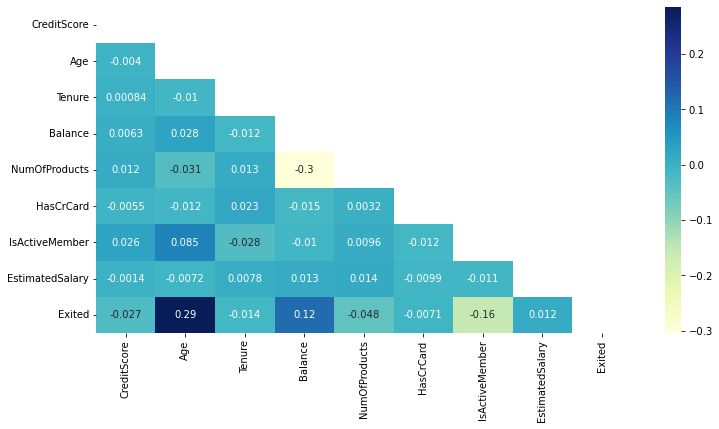

In [14]:
fig, ax = plt.subplots(figsize=(12,6))
matrix = np.triu(new_df.corr())
corr = new_df.corr()
corr_matrix = sns.heatmap(corr, annot=True, cmap="YlGnBu", mask = matrix)

There aren't many features with marginal correlation with target features.
As seen above, *Age* is the variable with the biggest correlation with the *y*.
You can see a slight (positive) correlation of *Balance* and (negative) *IsActiveMember* with the *y*.

# Try new Variables

In [20]:
df_try = new_df.copy()
df_try["Wealth"] = df_try["Balance"]+df_try["EstimatedSalary"]
df_try["BalanceForProduct"] = df_try["Balance"]/df_try["NumOfProducts"]
df_try["Age*Balance"] = df_try["Age"]*df_try["Balance"]
corr_matrix = df_try.corr()
corr_matrix["Exited"].sort_values(ascending=False)

Exited               1.000000
Age                  0.285323
Age*Balance          0.205775
Balance              0.118533
BalanceForProduct    0.109806
Wealth               0.094755
EstimatedSalary      0.012097
HasCrCard           -0.007138
Tenure              -0.014001
CreditScore         -0.027094
NumOfProducts       -0.047820
IsActiveMember      -0.156128
Name: Exited, dtype: float64

In [23]:
new_df["Age*Balance"] = new_df["Age"]*new_df["Balance"]

In [24]:
new_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age*Balance
0,619,France,Female,42,2,0,1,1,1,101348,1,0
1,608,Spain,Female,41,1,83807,1,0,1,112542,0,3436087
2,502,France,Female,42,8,159660,3,1,0,113931,1,6705720
3,699,France,Female,39,1,0,2,0,0,93826,0,0
4,850,Spain,Female,43,2,125510,1,1,1,79084,0,5396930


# Split in X and y sets

In [25]:
X = new_df.drop('Exited', axis = 1).copy() 
X.head() 

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Age*Balance
0,619,France,Female,42,2,0,1,1,1,101348,0
1,608,Spain,Female,41,1,83807,1,0,1,112542,3436087
2,502,France,Female,42,8,159660,3,1,0,113931,6705720
3,699,France,Female,39,1,0,2,0,0,93826,0
4,850,Spain,Female,43,2,125510,1,1,1,79084,5396930


In [26]:
y = new_df['Exited'].copy()
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

# Encoding Categorical Features

In [27]:
X_encoded = pd.get_dummies(X, columns= ['Geography',
                                        'Gender'])
X_encoded = X_encoded.drop('Gender_Female', axis = 1).copy() 
X_encoded.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Age*Balance,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0,1,1,1,101348,0,1,0,0,0
1,608,41,1,83807,1,0,1,112542,3436087,0,0,1,0
2,502,42,8,159660,3,1,0,113931,6705720,1,0,0,0
3,699,39,1,0,2,0,0,93826,0,1,0,0,0
4,850,43,2,125510,1,1,1,79084,5396930,0,0,1,0


# Feature Scaling & split in train and test set

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [29]:
y_train

9254    0
1561    0
1670    1
6087    1
6669    1
       ..
5734    0
5191    0
5390    1
860     1
7270    0
Name: Exited, Length: 8000, dtype: int64

In [30]:
print(y_train.value_counts() / len(y_train))
print(y_test.value_counts() / len(y_test))

0    0.7945
1    0.2055
Name: Exited, dtype: float64
0    0.8035
1    0.1965
Name: Exited, dtype: float64


Unscaled data can adversely impact a model’s ability to make accurate predictions. 
Feature scaling does not always result in an improvement in model performance. There are some machine learning models that do not require feature scaling.
In this analysis, however, we want to use the Support Vector Machine as a Machine Learning (SVM) model.
A Support Vector Machine (SVM) is a very powerful and versatile Machine Learning model, capable of performing linear or nonlinear classification, regression, and even outlier detection.
SVMs are sensitive to the feature scales, as you can see in *Figure* below on the left plot, the vertical scale is much larger than the orizontal scale, so the widest possible street is close to horizontal. After feature scaling (e.g., using Scikit-Learn’s StandardScaler), the decision boundary looks much better (on the right plot).

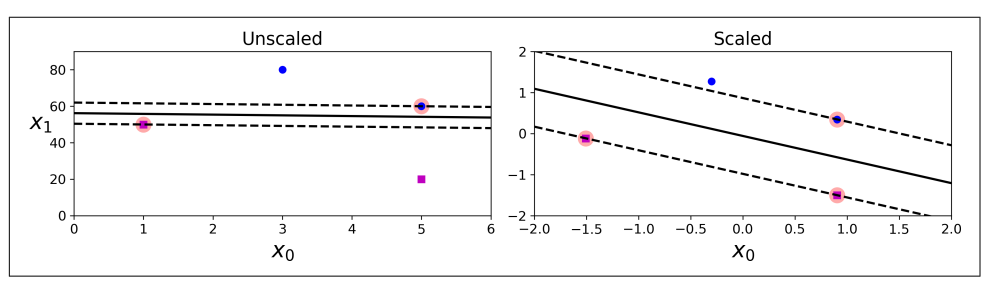

— *Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow*, 2019.

In [31]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Evaluation of different Models

The idea is to make an initial evaluation of several models and select the best ones.

In [32]:
filterwarnings('ignore')
models = [("linear_svc", LinearSVC(C=1, loss="hinge")), 
          ("gaussian_svc", SVC(kernel='rbf', random_state=0, gamma=1, C=0.5)),
          ("polynomial_svc", SVC(kernel='poly', degree=3, coef0=1, C=0.5)),
          ("RFC", RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1)),
           ("BC", BaggingClassifier(
            DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
             n_estimators=100, max_samples=1.0, bootstrap=True, n_jobs=-1)) 
         ]

results = []
names = []
finalResults = []

for name,model in models:
    model.fit(X_train, y_train)
    model_results = model.predict(X_test)
    score = precision_score(y_test, model_results, average='macro')
    results.append(score)
    names.append(name)
    finalResults.append((name,score))
    
finalResults.sort(key=lambda k:k[1],reverse=True)

In [33]:
finalResults

[('RFC', 0.8406601581724331),
 ('BC', 0.8348187027382462),
 ('polynomial_svc', 0.8186111111111112),
 ('gaussian_svc', 0.7987902057374674),
 ('linear_svc', 0.40175)]

Although linear SVM classifiers are efficient and work surprisingly well in many cases, many datasets are not even close to being linearly separable. 
This is one of those cases, as we can see nonlinear kernels work better. 
Random Forest and Bagging Classifier have a better performance than SVCs.

In [34]:
param_grid_SVC = {'C': [0.5, 1, 5],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}

In [35]:
gsRbf = GridSearchCV(SVC(),
                     param_grid = param_grid_SVC,
                     scoring='accuracy',
                     cv=5,
                     refit=True,
                     n_jobs=1)

In [36]:
# Train the SVM classifier
gsRbf.fit(X_train, y_train)

# Print the model parameters of the best model
print(gsRbf.best_params_)

# Print the model score on the test data using GridSearchCV score method
print('Test accuracy: %.3f' % gsRbf.score(X_test, y_test))

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Test accuracy: 0.860


In [37]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [True], 'n_estimators': [100, 150, 200], 'max_features': [2, 3, 4]},
  ]

forest_class = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(forest_class, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [True], 'max_features': [2, 3, 4],
                          'n_estimators': [100, 150, 200]}],
             return_train_score=True, scoring='accuracy')

In [38]:
print(grid_search.best_params_)
print('Test accuracy: %.3f' % grid_search.score(X_test, y_test))

{'bootstrap': True, 'max_features': 2, 'n_estimators': 200}
Test accuracy: 0.867


# Evaluation metrics

In [32]:
SVC_model = SVC(kernel='rbf', random_state=42, gamma=0.1, C=1)
RFC_model = RandomForestClassifier(random_state=42, n_estimators=200, max_features = 2, max_leaf_nodes=16)

0.8595
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1607
           1       0.76      0.41      0.54       393

    accuracy                           0.86      2000
   macro avg       0.82      0.69      0.73      2000
weighted avg       0.85      0.86      0.84      2000



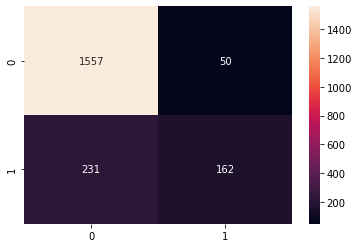

In [33]:
SVC_model = SVC_model.fit(X_train, y_train)
pred_SVC = SVC_model.predict(X_test)
print(accuracy_score(y_test, pred_SVC))
print(classification_report(y_test, pred_SVC))
sns.heatmap(confusion_matrix(y_test, pred_SVC), annot=True, fmt='d')
plt.show()

0.838
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1607
           1       0.86      0.21      0.34       393

    accuracy                           0.84      2000
   macro avg       0.85      0.60      0.62      2000
weighted avg       0.84      0.84      0.80      2000



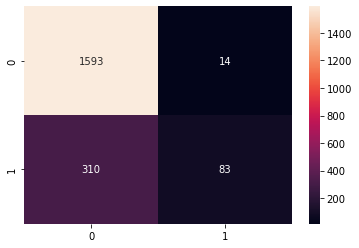

In [34]:
RFC_model = RFC_model.fit(X_train, y_train)
pred_RFC = RFC_model.predict(X_test)
print(accuracy_score(y_test, pred_RFC))
print(classification_report(y_test, pred_RFC))
sns.heatmap(confusion_matrix(y_test, pred_RFC), annot=True, fmt='d')
plt.show()

It is possible to notice how the SVC performs better, however, observing the Recall index for classes 1 the performance is not good.
To try to improve performance we will proceed with the balancing of the dataset.

# SMOTE for Imbalanced Classification

A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.
SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [35]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(X_train), len(y_train)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(X_test), len(y_test)))

Length of X (train): 8000 | Length of y (train): 8000
Length of X (test): 2000 | Length of y (test): 2000


In [36]:
smote = SMOTE(random_state = 42)
X_res, y_res = smote.fit_resample(X_train, y_train)
print('Length of X (resample): {} | Length of y (resample): {}'.format(len(X_res), len(y_res)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(X_test), len(y_test)))

Length of X (resample): 12712 | Length of y (resample): 12712
Length of X (test): 2000 | Length of y (test): 2000


0.7865
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1607
           1       0.47      0.71      0.57       393

    accuracy                           0.79      2000
   macro avg       0.70      0.76      0.71      2000
weighted avg       0.83      0.79      0.80      2000



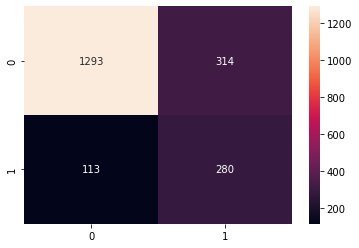

In [37]:
SVC_model = SVC_model.fit(X_res, y_res)
pred_SVC_im = SVC_model.predict(X_test)
print(accuracy_score(y_test, pred_SVC_im))
print(classification_report(y_test, pred_SVC_im))
sns.heatmap(confusion_matrix(y_test, pred_SVC_im), annot=True, fmt='d')
plt.show()

0.7895
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1607
           1       0.48      0.74      0.58       393

    accuracy                           0.79      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.84      0.79      0.80      2000



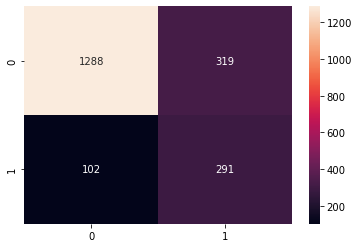

In [38]:
RFC_model = RFC_model.fit(X_res, y_res)
pred_RFC_im = RFC_model.predict(X_test)
print(accuracy_score(y_test, pred_RFC_im))
print(classification_report(y_test, pred_RFC_im))
sns.heatmap(confusion_matrix(y_test, pred_RFC_im), annot=True, fmt='d')
plt.show()

The rebalancing improved the classification of class 1.
In my opinion, given the nature of the problem, this solution is preferable even if it has a lower accuracy because I can better identify customers at risk of churn.

The model that seems to perform best in identifying customers at risk of churn is the Random Forest.

# Explainable Machine Learning with SHAP

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions

In [39]:
col = X_encoded.columns.values.tolist()
col

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Age*Balance',
 'Geography_France',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male']

In [40]:
X_res_ex = pd.DataFrame(X_res, columns= col)
X_res_ex.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Age*Balance,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
0,0.356500,-0.655786,0.345680,-1.218470,0.808436,0.649203,0.974817,1.367674,-1.126435,1.001501,-0.579467,-0.576388,0.913248
1,-0.203898,0.294938,-0.348369,0.696836,0.808436,0.649203,0.974817,1.661248,0.773701,-0.998501,1.725723,-0.576388,0.913248
2,-0.961472,-1.416365,-0.695393,0.618622,-0.916688,0.649203,-1.025834,-0.252799,-0.084983,-0.998501,-0.579467,1.734942,0.913248
3,-0.940717,-1.131148,1.386753,0.953220,-0.916688,0.649203,-1.025834,0.915394,0.258595,1.001501,-0.579467,-0.576388,-1.094993
4,-1.397337,1.625953,1.386753,1.057452,-0.916688,-1.540351,-1.025834,-1.059592,1.884095,1.001501,-0.579467,-0.576388,0.913248


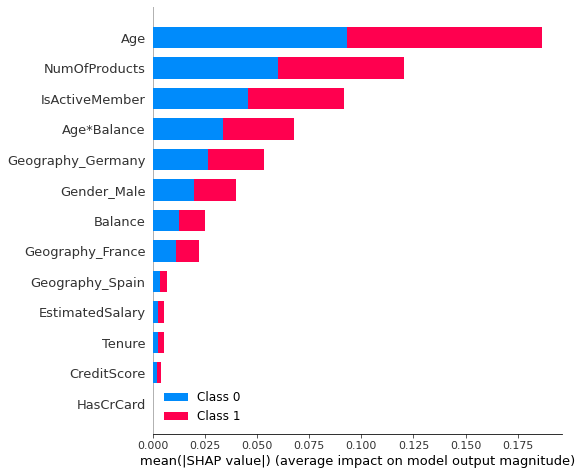

In [41]:
shap_values = shap.TreeExplainer(RFC_model).shap_values(X_res_ex)
shap.summary_plot(shap_values, X_res_ex, plot_type="bar")

In [42]:
X_test_ex = pd.DataFrame(X_test, columns= col)
X_test_ex.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Age*Balance,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
0,-0.577496,-0.655786,-0.695393,0.329942,0.808436,-1.540351,-1.025834,-1.019603,0.043964,-0.998501,1.725723,-0.576388,0.913248
1,-0.297297,0.390011,-1.389442,-1.218470,0.808436,0.649203,0.974817,0.798886,-1.126435,1.001501,-0.579467,-0.576388,0.913248
2,-0.525607,0.485083,-0.348369,-1.218470,0.808436,0.649203,-1.025834,-0.727976,-1.126435,-0.998501,-0.579467,1.734942,-1.094993
3,-1.511492,1.911170,1.039728,0.689278,0.808436,0.649203,0.974817,1.221382,1.532272,-0.998501,1.725723,-0.576388,0.913248
4,-0.951094,-1.131148,0.692704,0.782831,-0.916688,0.649203,0.974817,0.247555,0.149926,-0.998501,-0.579467,1.734942,-1.094993


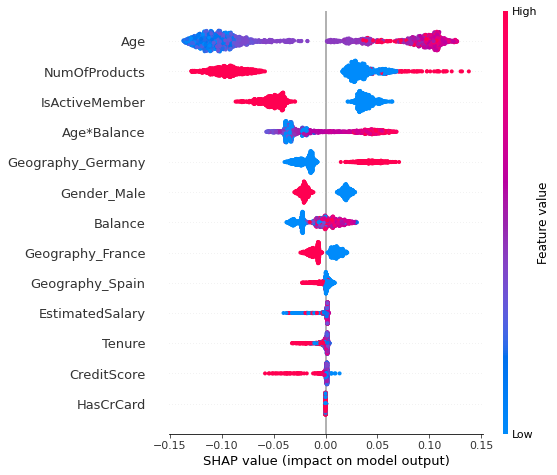

In [43]:
explainer_k = shap.TreeExplainer(RFC_model)

shap_values_k = explainer_k.shap_values(X_test_ex)

shap.summary_plot(shap_values_k[1], X_test_ex)

In [44]:
row_to_show = 5
data_for_prediction = X_test_ex.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

In [45]:
RFC_model.predict_proba(data_for_prediction_array)

array([[0.79921226, 0.20078774]])

In [46]:
shap_values = explainer_k.shap_values(data_for_prediction)

In [47]:
shap.initjs()
shap.force_plot(explainer_k.expected_value[1], shap_values[1], data_for_prediction)

Note: you may need to restart the kernel to use updated packages.

Solving environment: ...working... done

# All requested packages already installed.

